In [1]:
import os; os.chdir('..')

In [2]:
from jobs.specs import dev_vaei3d_smth as opts
from models.vae_i3d import VAEI3D
from pipeline.smth import SmthDataBunch
from models.engine import _prepare_batch
import constants as ct

import dataclasses as dc
import torch as th
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def pic_show(_video):
    num = len(_video)
    fig = plt.figure(figsize=(16, 32), dpi=80)
    for i in range(1,num+1):
        sub = fig.add_subplot(1,num,i)
        sub.set_title(str(i))
        sub.axis('off')
        sub.imshow(_video[i-1])
    plt.show()

def un_normalize(_x):
    return _x * 255

def un_standardize(_x):
    means = th.tensor(ct.IMAGE_NET_MEANS).reshape((1, 3, 1, 1))
    stds = th.tensor(ct.IMAGE_NET_STDS).reshape((1, 3, 1, 1))
    
    return _x * stds + means

In [4]:
opts.trainer_opts.optimizer_opts.lr = 0.005
opts.valid_dl_opts.batch_size = 1
opts.trainer_opts.criterion_opts.mse_factor = 512.0
opts.trainer_opts.criterion_opts.ce_factor = 0.0
opts.trainer_opts.criterion_opts.kld_factor = 1.0
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

model = VAEI3D(**dc.asdict(opts.model_opts)).to(device)
bunch = SmthDataBunch(opts.db_opts, opts.train_ds_opts, opts.valid_ds_opts, opts.train_dl_opts, opts.valid_dl_opts)
optimizer = opts.trainer_opts.optimizer(model.parameters(), **dc.asdict(opts.trainer_opts.optimizer_opts))
loss_fn = opts.trainer_opts.criterion(**dc.asdict(opts.trainer_opts.criterion_opts)).to(device)
lr_scheduler = th.optim.lr_scheduler.StepLR(optimizer, 100, 0.5)

In [5]:
batch = next(iter(bunch.valid_loader))
video, label = bunch.valid_set[0]
x, y = _prepare_batch(batch, device, False)

In [6]:
video, label

(Video 172305 (4x3x224x224), (6 Throwing something))

In [12]:
for _ in range(200):
    model.train()
    optimizer.zero_grad()
    _recon, _pred, _latent, _mean, _log_var, _vote = model(x, inference=False, num_samples=1)
    mse, ce, kld = loss_fn(_recon, _pred.view(1, 30), x, y, _mean, _log_var)
    (mse + ce + kld).backward()
    print(f'{_}={mse:.4f} | {ce:.4f}| {kld:.4f}')
    optimizer.step()
    lr_scheduler.step()

0=15315222.0000 | 0.0000| 10252.1016
1=15060533.0000 | 0.0000| 7250.2148
2=14935899.0000 | 0.0000| 14209.0488
3=14834469.0000 | 0.0000| 9125.4688
4=14818749.0000 | 0.0000| 9353.0918
5=14743270.0000 | 0.0000| 10990.8008
6=14675720.0000 | 0.0000| 8277.0303
7=14642246.0000 | 0.0000| 9400.7500
8=14541739.0000 | 0.0000| 11170.5820
9=14536257.0000 | 0.0000| 10236.2461
10=14437452.0000 | 0.0000| 11446.7695
11=14408329.0000 | 0.0000| 9655.3379
12=14333170.0000 | 0.0000| 10097.7227
13=14310367.0000 | 0.0000| 9426.8848
14=14234282.0000 | 0.0000| 8367.4658
15=14198022.0000 | 0.0000| 11703.9883
16=14137148.0000 | 0.0000| 10460.2480
17=14091834.0000 | 0.0000| 10378.6445
18=14046685.0000 | 0.0000| 8580.3623
19=13987226.0000 | 0.0000| 10854.0010
20=13952264.0000 | 0.0000| 12078.6992
21=13898878.0000 | 0.0000| 10307.8184
22=13848947.0000 | 0.0000| 10028.1523
23=13805932.0000 | 0.0000| 11285.4043
24=13766265.0000 | 0.0000| 10985.2119
25=13711404.0000 | 0.0000| 9039.4814
26=13664821.0000 | 0.0000| 11236

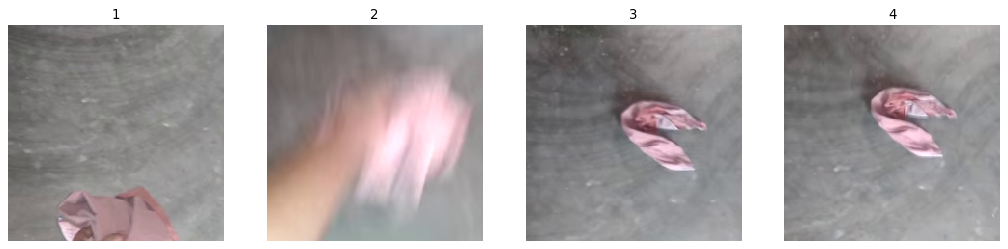

In [13]:
_in = video.data.astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_in)

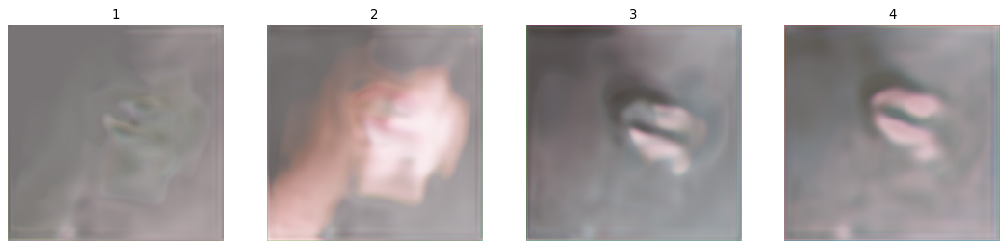

In [14]:
_rec = un_normalize(un_standardize(_recon.detach().cpu()))
_rec = _rec.numpy().reshape(4, 3, 224, 224).astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_rec)

In [15]:
_recon.min(), _recon.max(), _rec.min(), _rec.max()

(tensor(-0.9245, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(2.3942, device='cuda:0', grad_fn=<MaxBackward1>),
 63,
 250)

In [16]:
un_standardize(_recon.detach().cpu()).min(), un_standardize(_recon.detach().cpu()).max()

(tensor(0.2489), tensor(0.9821))